In [ ]:
import pandas as pd
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [6]:
# Load the dataset from backend/datasets
path = os.path.abspath(os.path.join(os.getcwd(), "..", "datasets", "anime.csv"))
df = pd.read_csv(path)
df.head()

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28148 entries, 0 to 28147
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           28148 non-null  object 
 1   Title English   11996 non-null  object 
 2   Title Japanese  28031 non-null  object 
 3   Type            28073 non-null  object 
 4   Source          28148 non-null  object 
 5   Episodes        27441 non-null  float64
 6   Status          28148 non-null  object 
 7   Airing          28148 non-null  bool   
 8   Aired From      27265 non-null  object 
 9   Aired To        10820 non-null  object 
 10  Score           18120 non-null  float64
 11  Rank            21531 non-null  float64
 12  Popularity      28148 non-null  int64  
 13  Members         28148 non-null  int64  
 14  Favorites       28148 non-null  int64  
 15  Synopsis        23079 non-null  object 
 16  Studios         16534 non-null  object 
 17  Genres          22352 non-null 

In [7]:
# Basic exploration

df.shape
df.info()
df.columns
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28148 entries, 0 to 28147
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           28148 non-null  object 
 1   Title English   11996 non-null  object 
 2   Title Japanese  28031 non-null  object 
 3   Type            28073 non-null  object 
 4   Source          28148 non-null  object 
 5   Episodes        27441 non-null  float64
 6   Status          28148 non-null  object 
 7   Airing          28148 non-null  bool   
 8   Aired From      27265 non-null  object 
 9   Aired To        10820 non-null  object 
 10  Score           18120 non-null  float64
 11  Rank            21531 non-null  float64
 12  Popularity      28148 non-null  int64  
 13  Members         28148 non-null  int64  
 14  Favorites       28148 non-null  int64  
 15  Synopsis        23079 non-null  object 
 16  Studios         16534 non-null  object 
 17  Genres          22352 non-null 

,Episodes,Score,Rank,Popularity,Members,Favorites
count,27441.000000,18120.000000,21531.000000,28148.000000,2.814800e+04,28148.000000
mean,14.279655,6.402958,10744.497051,13997.900064,3.816941e+04,429.534674
std,47.657536,0.890196,6203.811579,8078.025251,1.644889e+05,4465.005161
min,1.000000,1.880000,1.000000,1.000000,1.000000e+00,0.000000
25%,1.000000,5.780000,5374.500000,7006.750000,2.240000e+02,0.000000
50%,2.000000,6.380000,10745.000000,13987.000000,1.065500e+03,1.000000
75%,13.000000,7.040000,16121.500000,20993.250000,9.116000e+03,17.000000
max,3057.000000,9.310000,21486.000000,28004.000000,4.108505e+06,233755.000000


In [8]:
# feature engineering: combine relevant text features into a single string

df = df[['Title', 'Genres', 'Synopsis']]
df.head()


,Title,Genres,Synopsis
0,Cowboy Bebop,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ..."
1,Cowboy Bebop: Tengoku no Tobira,"Action, Sci-Fi","Another day, another bounty—such is the life o..."
2,Trigun,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0..."
3,Witch Hunter Robin,"Action, Drama, Mystery, Supernatural","Though hidden away from the general public, Wi..."
4,Bouken Ou Beet,"Action, Adventure, Fantasy",It is the dark century and the people are suff...


In [9]:
# checking for missing values
df.isnull().sum()

# drop rows with missing values in 'Genres' or 'Synopsis'
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.isnull().sum()


# checking for duplicates Title
df.duplicated(subset=['Title']).sum()
df.drop_duplicates(subset=['Title'], inplace=True)
df.reset_index(drop=True, inplace=True)

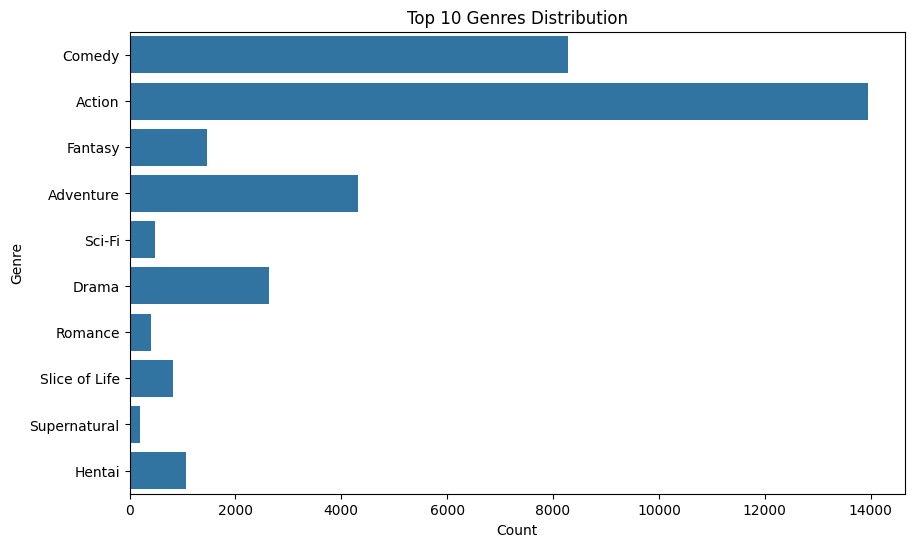

In [10]:
# Explore the distribution of 'Genres' using visualization
df['Genres'].str.split(', ').explode().value_counts().head(10)
plt.figure(figsize=(10,6))
sns.countplot(y=df['Genres'].str.split(',').explode(), order=df['Genres'].str.split(', ').explode().value_counts().index[:10])
plt.title('Top 10 Genres Distribution')
plt.xlabel('Count') 
plt.ylabel('Genre')
plt.show()



In [11]:
# feature engineering: combine relevant text features into a single string Genres + Synopsis + Title
df['Combined'] = df['Title'] + ' ' + df['Genres'] + ' ' + df['Synopsis']
df[['Title', 'Combined']].head()


,Title,Combined
0,Cowboy Bebop,"Cowboy Bebop Action, Award Winning, Sci-Fi Cri..."
1,Cowboy Bebop: Tengoku no Tobira,"Cowboy Bebop: Tengoku no Tobira Action, Sci-Fi..."
2,Trigun,"Trigun Action, Adventure, Sci-Fi Vash the Stam..."
3,Witch Hunter Robin,"Witch Hunter Robin Action, Drama, Mystery, Sup..."
4,Bouken Ou Beet,"Bouken Ou Beet Action, Adventure, Fantasy It i..."


In [12]:
# TF-IDF Vectorization for text features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Combined'])
tfidf_matrix.shape
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim.shape


(18835, 18835)

In [13]:
def recommend_anime(anime_name, top_n=10):
    if anime_name not in df['Title'].values:
        return []

    idx = df[df['Title'] == anime_name].index[0]

    similarity_scores = list(enumerate(cosine_sim[idx]))
    similarity_scores = sorted(
        similarity_scores, 
        key=lambda x: x[1], 
        reverse=True
    )

    top_anime_indices = similarity_scores[1:top_n+1]

    return [df.iloc[i[0]]['Title'] for i in top_anime_indices]

# Example usage
recommended_anime = recommend_anime("Naruto", top_n=5)
print("Recommended Anime:", recommended_anime)

Recommended Anime: ['Naruto: Shippuuden', 'Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi', 'Naruto: Shippuuden Movie 6 - Road to Ninja', 'Boruto: Naruto Next Generations', 'Naruto: Shippuuden - Shippuu! "Konoha Gakuen" Den']
